### Imports

In [3]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import solve_ivp
from scipy.linalg import expm
import matplotlib.ticker as ticker

### Problem Params

In [44]:
PARAMS = {
    'm': 0.3,
    'k_D': 0.5,
    'g_val': -9.81, # Gravity points "Up"
    'T_min': 1.0,
    'T_max': 4.0,
    'theta_max': np.deg2rad(45),
    'N': 31,
    'tf': 3.0,
    'dt': 3.0 / (31 - 1),
    'x_ic': np.array([0, 0, 0, 0, 0.5, 0]),  # p_ic, v_ic
    'x_fc': np.array([0, 10, 0, 0, 0.5, 0]), # p_fc, v_fc
    'obstacles': [
        {'p_obs': np.array([0, 3, 0.45]), 'R_obs': 1.0},
        {'p_obs': np.array([0, 7, -0.45]), 'R_obs': 1.0}
    ]
}
PARAMS['cos_theta_max'] = np.cos(PARAMS['theta_max'])
PARAMS['u_ic'] = np.array([-PARAMS['m']*PARAMS['g_val'], 0, 0])
PARAMS['u_fc'] = np.array([-PARAMS['m']*PARAMS['g_val'], 0, 0])


SCVX_PARAMS = {
    'max_iters': 50,
    'max_iter_attempts': 50,
    'lambda_v': 1e5,  # Penalty for virtual control (dynamics)
    'lambda_s': 1e5,  # Penalty for virtual buffer (obstacles)
    'r_0': 100.0,      # Initial trust region radius
    'r_min': 1e-3,
    'r_max': 1e3,
    'rho_0': 0.00,    # Rho thresholds for trust region update
    'rho_1': 0.25,
    'rho_2': 0.7,
    'alpha': 2.0,     # Trust region shrink factor
    'beta': 3.2,      # Trust region grow factor
    'tol': 5e-2       # Convergence tolerance
}

### Symbolic Defs

In [5]:
# p_x = Up, p_y = East, p_z = North
px, py, pz, vx, vy, vz, Tx, Ty, Tz = sym.symbols('p_x, p_y, p_z, v_x, v_y, v_z, T_x, T_y, T_z', real=True)
p = sym.Matrix([px, py, pz])
v = sym.Matrix([vx, vy, vz])
T = sym.Matrix([Tx, Ty, Tz])

# State vector x = [p, v] (6x1)
x_sym = sym.Matrix([p, v])
nx = x_sym.shape[0]
# Control vector u = T (3x1)
u_sym = T
nu = u_sym.shape[0]

# Parameters
dt, m, kD = sym.symbols('dt, m, k_D', real=True)
g_val = sym.symbols('g_val', real=True) # Note: g is a scalar value
g_vec = sym.Matrix([g_val, 0, 0]) # Gravity vector in Up-East-North

# Non-convex obstacle constraint: s(x) <= 0
R_obs, p_obs_x, p_obs_y, p_obs_z = sym.symbols('R_obs, p_obs_x, p_obs_y, p_obs_z', real=True)
p_obs = sym.Matrix([p_obs_x, p_obs_y, p_obs_z])

### Symbolic Dynamics and Constraints

In [6]:
# Dynamics
a = (1/m * T) - kD * v.norm(2) * v + g_vec # acceleration
f = sym.Matrix([v, a]) # real, nonlinear dynamics, we will linearize/discretize in subproblem creation

# obstacle constraint (non-convex)
# s_obs = R_obs - ||p - p_obs|| <= 0
s_obs = sym.Matrix([R_obs - (p - p_obs).norm(2)])
display(f, s_obs)

Matrix([
[                                                   v_x],
[                                                   v_y],
[                                                   v_z],
[T_x/m + g_val - k_D*v_x*sqrt(v_x**2 + v_y**2 + v_z**2)],
[        T_y/m - k_D*v_y*sqrt(v_x**2 + v_y**2 + v_z**2)],
[        T_z/m - k_D*v_z*sqrt(v_x**2 + v_y**2 + v_z**2)]])

Matrix([[R_obs - sqrt((p_obs_x - p_x)**2 + (p_obs_y - p_y)**2 + (p_obs_z - p_z)**2)]])

### Jacobians and Lamdifications

In [7]:
A = f.jacobian(x_sym)
B = f.jacobian(u_sym)
display(A, B)

S_obs = s_obs.jacobian(x_sym)
Q_obs = s_obs.jacobian(u_sym)
display(S_obs, Q_obs)

all_symbols = list(x_sym) + list(u_sym) + [m, kD, g_val, dt]
obs_symbols = [R_obs, p_obs_x, p_obs_y, p_obs_z]

f_lam = sym.lambdify(all_symbols, f, 'numpy')
A_lam = sym.lambdify(all_symbols, A, 'numpy')
B_lam = sym.lambdify(all_symbols, B, 'numpy')

s_obs_lam = sym.lambdify(list(x_sym) + obs_symbols, s_obs, 'numpy')
S_lam = sym.lambdify(list(x_sym) + obs_symbols, S_obs, 'numpy')
Q_lam = sym.lambdify(list(x_sym) + obs_symbols, Q_obs, 'numpy')

def f_func(x_val: np.ndarray, u_val: np.ndarray):
    args = list(x_val) + list(u_val) + [PARAMS['m'], PARAMS['k_D'], PARAMS['g_val'], PARAMS['dt']]
    return f_lam(*args).flatten()

def A_func(x_val: np.ndarray, u_val: np.ndarray):
    args = list(x_val) + list(u_val) + [PARAMS['m'], PARAMS['k_D'], PARAMS['g_val'], PARAMS['dt']]
    return A_lam(*args)

def B_func(x_val: np.ndarray, u_val: np.ndarray):
    args = list(x_val) + list(u_val) + [PARAMS['m'], PARAMS['k_D'], PARAMS['g_val'], PARAMS['dt']]
    return B_lam(*args)

def s_obs_func(x_val: np.ndarray, obs: dict):
    args = list(x_val) + [obs['R_obs']] + list(obs['p_obs'])
    return s_obs_lam(*args).flatten()[0] # Need this to return a float not a vector

def S_func(x_val: np.ndarray, obs: dict):
    args = list(x_val) + [obs['R_obs']] + list(obs['p_obs'])
    return S_lam(*args)

def Q_func(x_val: np.ndarray, obs: dict):
    args = list(x_val) + [obs['R_obs']] + list(obs['p_obs'])
    return Q_lam(*args)

Matrix([
[0, 0, 0,                                                                               1,                                                                               0,                                                                               0],
[0, 0, 0,                                                                               0,                                                                               1,                                                                               0],
[0, 0, 0,                                                                               0,                                                                               0,                                                                               1],
[0, 0, 0, -k_D*v_x**2/sqrt(v_x**2 + v_y**2 + v_z**2) - k_D*sqrt(v_x**2 + v_y**2 + v_z**2),                                     -k_D*v_x*v_y/sqrt(v_x**2 + v_y**2 + v_z**2),                                     -k_D*v_x*v_z/sqrt(v_x

Matrix([
[  0,   0,   0],
[  0,   0,   0],
[  0,   0,   0],
[1/m,   0,   0],
[  0, 1/m,   0],
[  0,   0, 1/m]])

Matrix([[-(-p_obs_x + p_x)/sqrt((p_obs_x - p_x)**2 + (p_obs_y - p_y)**2 + (p_obs_z - p_z)**2), -(-p_obs_y + p_y)/sqrt((p_obs_x - p_x)**2 + (p_obs_y - p_y)**2 + (p_obs_z - p_z)**2), -(-p_obs_z + p_z)/sqrt((p_obs_x - p_x)**2 + (p_obs_y - p_y)**2 + (p_obs_z - p_z)**2), 0, 0, 0]])

Matrix([[0, 0, 0]])

### Convenience Defintions

In [8]:
dt = PARAMS['dt']
N = PARAMS['N']

### Convex Cost $C$

In [9]:
def C_func(gamma: np.ndarray):
    """
    Calculates the original convex cost function from problem defintion
    """
    return np.sum(gamma) * dt

### Realized Cost Function $J$

In [10]:
def J_func(x: np.ndarray, u: np.ndarray, gamma: np.ndarray, verbose: bool = False):
    """
    Calculates the "actual" non-convex penalized cost J(x, u) from Eq. 2.6/3.2.
    J = C(x,u,gamma)                       # Real cost
    + sum(lambda_v * |x_next - f(x, u)|)   # Real dynamic error
    + sum(lambda_s * max(0, s(x, u)))      # Real constraint violation
    """
    C = C_func(gamma)

    def f_FOH(t: float, x: np.ndarray, u_i0: np.ndarray, u_i1: np.ndarray):
        # Calculates the FOH on the input and plugs into the non-linear dynamics
        beta_m = (dt - t)/dt
        beta_p = t / dt
        u_t = beta_m*u_i0 + beta_p*u_i1
        return f_func(x, u_t)
    
    v_error = 0.0
    for i in range(N-1): # N total x and u
        x_i0 = x[i]
        x_i1 = x[i+1]
        u_i0 = u[i]
        u_i1 = u[i+1]

        # numerically integrate the real dynamics one dt
        sol = solve_ivp(
            f_FOH,
            [0, dt],
            x_i0,
            args = (u_i0, u_i1)
        )
        
        # v_error += np.linalg.norm(x_i1 - sol.y[:,-1], ord = 1)
        v_error += np.sum(np.abs(x_i1 - sol.y[:,-1]))

    s_error = 0.0
    for obs in PARAMS['obstacles']:
        for i in range(N):
            s_error += max(0.0, s_obs_func(x[i], obs))

    if verbose:
        print(f'  C = {C}')
        print(f'  v_error = {v_error}')
        # print(f'  x_i+1 = {x_i1},\nf(x,u) = {sol.y[:, -1]}')
        print(f'  s_error = {s_error}')

    return C + SCVX_PARAMS['lambda_v']*v_error + SCVX_PARAMS['lambda_s']*s_error
    

### Discretization

In [11]:
def get_discrete_matrices(x_ki, u_ki):
    """
    Computes the discretized matrices for a single interval [i, i+1] using Van Loan's method.

    This implementation linearizes the system at the start of the
    interval (x_k_i, u_k_i) and assumes the resulting A, B, and z
    matrices are constant over the interval.
    
    It computes the integrals for:
    x(i+1) = A_d*x(i) + B_d_minus*u(i) + B_d_plus*u(i+1) + z_d
    """
    A_i = A_func(x_ki, u_ki)
    B_i = B_func(x_ki, u_ki)
    f_i = f_func(x_ki, u_ki)
    z_i = f_i - A_i @ x_ki - B_i @ u_ki

    M = np.block([[A_i,                np.eye(nx),         np.zeros((nx, nx))],
                  [np.zeros((nx, nx)), np.zeros((nx, nx)), np.eye(nx)],
                  [np.zeros((nx, nx)), np.zeros((nx, nx)), np.zeros((nx, nx))]])
    
    F = expm(M*dt)
    F11 = F[0:nx, 0:nx]
    F12 = F[0:nx, nx:2*nx]
    F13 = F[0:nx, 2*nx:3*nx]

    A_d = F11
    B_dm = F12 @ B_i - 1/dt*F13 @ B_i
    B_dp = 1/dt * F13 @ B_i
    z_d = F12 @ z_i
    return A_d, B_dm, B_dp, z_d

### LTV Discretization

In [12]:
x_ind = slice(0, nx)
phi_ind = slice(nx, nx + nx*nx)
bdm_ind = slice(nx + nx*nx, nx + nx*nx + nx*nu)
bdp_ind = slice(nx + nx*nx + nx*nu, nx + nx*nx + 2*nx*nu)
zd_ind = slice(nx + nx*nx + 2*nx*nu, nx + nx*nx + 2*nx*nu + nx)
V_SIZE = nx + nx*nx + 2*nx*nu + nx # 6 + 36 + 18 + 18 + 6 = 84

def _integrate_ltv_dynamics(t, V, u_ki, u_ki1):
    """
    This function is passed to the ODE integrator (solve_ivp).
    It computes the derivatives of the augmented state vector V at time t.
    """
    
    # Unpack the flat state vector V
    x = V[x_ind]
    Phi_A = V[phi_ind].reshape((nx, nx))
    
    # Calculate FOH control u(t)
    alpha = (dt - t) / dt
    beta = t / dt
    u = alpha * u_ki + beta * u_ki1
    
    # Relinearize at each timestep
    A_t = A_func(x, u)
    B_t = B_func(x, u)
    f_t = f_func(x, u)
    z_t = f_t - A_t @ x - B_t @ u
    
    # Compute derivatives of all parts of V
    dVdt = np.zeros(V_SIZE)
    
    dVdt[x_ind] = f_t
    
    d_Phi_A_dt = A_t @ Phi_A
    dVdt[phi_ind] = d_Phi_A_dt.ravel()
    
    try:
        Phi_A_inv = np.linalg.inv(Phi_A)
    except np.linalg.LinAlgError:
        Phi_A_inv = np.eye(nx)

    d_B_dm_dt = Phi_A_inv @ B_t * alpha
    d_B_dp_dt = Phi_A_inv @ B_t * beta
    d_z_d_dt = Phi_A_inv @ z_t
    
    dVdt[bdm_ind] = d_B_dm_dt.ravel()
    dVdt[bdp_ind] = d_B_dp_dt.ravel()
    dVdt[zd_ind] = d_z_d_dt
    
    return dVdt

def get_discrete_matrices_ltv(x_ki, u_ki, u_ki1):
    """
    Computes the discretized matrices for a single interval [i, i+1]
    using LTV integration of the variational equations.
    """
    
    # Set up the initial augmented state V0
    V0 = np.zeros(V_SIZE)
    V0[x_ind] = x_ki
    V0[phi_ind] = np.eye(nx).ravel()
    # B_dm, B_dp, z_d integrals start at 0
    
    # Integrate the LTV dynamics over the interval [0, dt]
    sol = solve_ivp(
        _integrate_ltv_dynamics,
        [0, dt],
        V0,
        method='RK45',
        args=(u_ki, u_ki1)
    )
    
    # Get the final state vector from the end of the integration
    V_final = sol.y[:, -1]
    
    # Extract the integrated matrices
    A_d = V_final[phi_ind].reshape((nx, nx))
    B_dm_int = V_final[bdm_ind].reshape((nx, nu))
    B_dp_int = V_final[bdp_ind].reshape((nx, nu))
    z_d_int = V_final[zd_ind]
    
    # Post-multiply by A_d (Phi_A(dt, 0)) to get the correct form
    # This is the standard solution for LTV state-space integrals
    B_dm = A_d @ B_dm_int
    B_dp = A_d @ B_dp_int
    z_d = A_d @ z_d_int
    
    return A_d, B_dm, B_dp, z_d

### Convex Subproblem

In [32]:
def solve_convex_subproblem(x_k, 
                            u_k, 
                            r_k, 
                            A_d = None,
                            B_dm = None,
                            B_dp = None,
                            z_d = None,
                            verbose=True):
    if A_d is None or B_dm is None or B_dp is None or z_d is None:
        get_constants = True
    else:
        get_constants = False

    n_obs = len(PARAMS['obstacles'])

    x = cp.Variable((N, nx)) # State
    u = cp.Variable((N, nu)) # Control
    gamma = cp.Variable(N)   # Control convexifying variable

    v = cp.Variable((N - 1, nx)) # Virtual control (dynamics)
    sp = cp.Variable((N, n_obs)) # Virtual buffer (obstacles)

    # Objective: L^k = C(new) + Penalties
    objective = cp.sum(gamma) * dt

    # for i in range(N-1):
    #     objective += SCVX_PARAMS['lambda_v'] * cp.norm(v[i], 1)
    # for i in range(N):
    #     for j in range(n_obs):
    #         objective += SCVX_PARAMS['lambda_s'] * cp.pos(sp[i,j])
    objective += SCVX_PARAMS['lambda_v'] * cp.norm(v, 1)
    objective += SCVX_PARAMS['lambda_s'] * cp.sum(cp.pos(sp))

    # --- Constraints --- #
    constraints = []
    for i in range(N):
        # Planar motion
        constraints.append(x[i, 0] == 0)

        # Thrust magnitude
        constraints.append(cp.norm(u[i], 2) <= gamma[i])

        # Thrust limits
        constraints.append(gamma[i] >= PARAMS['T_min'])
        constraints.append(gamma[i] <= PARAMS['T_max'])

        # Tilt angle
        constraints.append(PARAMS['cos_theta_max'] *gamma[i] <= u[i, 0])

        # Obstacles s(x_k) + S_k * (x* - xk) <= s_prime
        for j, obs in enumerate(PARAMS['obstacles']):
            s_obs = s_obs_func(x_k[i], obs)
            S_obs = S_func(x_k[i], obs)
            d = x[i] - x_k[i]
            constraints.append(s_obs + S_obs @ d <= sp[i, j])
            constraints.append(sp[i, j] >= 0)

        # Dynamics
        if i < N-1:
            if get_constants:
                A_d, B_dm, B_dp, z_d = get_discrete_matrices_ltv(x_k[i], u_k[i], u_k[i+1])
                constraints.append(
                    x[i+1] == A_d @ x[i] 
                    + B_dm @ u[i] 
                    + B_dp @ u[i+1] 
                    + z_d 
                    + v[i]
                )
            else:
                constraints.append(
                    x[i+1] == A_d[i] @ x[i] 
                    + B_dm[i] @ u[i] 
                    + B_dp[i] @ u[i+1] 
                    + z_d[i] 
                    + v[i]
                )

    # Boundary conditions
    constraints.append(x[0] == PARAMS['x_ic'])
    constraints.append(x[-1] == PARAMS['x_fc'])
    constraints.append(u[0] == PARAMS['u_ic'])
    constraints.append(u[-1] == PARAMS['u_fc'])

    # Trust region
    # constraints.append(cp.norm(x, 1) + cp.norm(u, 1) <= r_k)
    # May be more technically correct?
    # constraints.append(cp.norm(x - x_k, 1) + cp.norm(u - u_k, 1) <= r_k)
    # May be even more technically correct?
    constraints.append(cp.norm(u - u_k, 1) <= r_k)


    prob = cp.Problem(cp.Minimize(objective), constraints)
    try:
        prob.solve(solver=cp.SCS, verbose=verbose)
    except cp.SolverError:
        print("Solver failed. Trying with ECOS.")
        try:
            prob.solve(solver=cp.ECOS, verbose=verbose)
        except cp.SolverError:
            print("Both solvers failed.")
            return None

    # Return the solution
    return x, u, gamma, v, sp, prob.status, prob.value

### Construct Intial Guess

In [27]:
def create_init_guess():
    x_guess = np.zeros((N, nx))
    u_guess = np.zeros((N, nu))
    for i in range(N):
        alpha = i / (N - 1)
        x_guess[i, :] = (1 - alpha) * PARAMS['x_ic'] + alpha * PARAMS['x_fc']
        u_guess[i, :] = (1 - alpha) * PARAMS['u_ic'] + alpha * PARAMS['u_fc']

    # gamma_guess = np.linalg.norm(u_k, axis=1)
    gamma_guess = PARAMS['T_max']*np.ones(N)
    return x_guess, u_guess, gamma_guess

### Iterative Solve

In [ ]:
VERBOSE_SOLVE = False

x_k, u_k, gamma_k = create_init_guess()

r_k = SCVX_PARAMS['r_0']

for k in range(SCVX_PARAMS['max_iters']):
    print(f"--- Iteration {k+1}/{SCVX_PARAMS['max_iters']} (r_k = {r_k}) ---")
    solve_result = solve_convex_subproblem(x_k, u_k, r_k, verbose=VERBOSE_SOLVE)

    if solve_result is None or solve_result[5] in [cp.INFEASIBLE, cp.UNBOUNDED]:
        print("  Solver failed or problem was infeasible. Shrinking trust region.")
        r_k = max(r_k / SCVX_PARAMS['alpha'], SCVX_PARAMS['r_min'])
        continue

    x_star, u_star, gamma_star, v_star, sp_star, status, L_k = solve_result

    print('\n  Original Cost:')
    J_k0 = J_func(x_k, u_k, gamma_k, verbose=True)
    print('\n  New Cost:')
    J_k1 = J_func(x_star.value, u_star.value, gamma_star.value, verbose=True)
    print('\n')

    delta_J = J_k0 - J_k1
    delta_L = J_k0 - L_k

    if np.abs(delta_L) < 1e-6:
        rho_k = -1.0 # Set to a "bad" value
        print("  Predicted reduction is near zero.")
    else:
        rho_k = delta_J / delta_L
        
    print(f"  J_k0 = {J_k0:.3f}, J_k1 = {J_k1:.3f}, L_k = {L_k:.3f}")
    print(f"  Actual reduction  (Delta J) = {delta_J:.3e}")
    print(f"  Predicted reduction (Delta L) = {delta_L:.3e}")
    print(f"  Ratio (rho_k) = {rho_k}")

    if rho_k < SCVX_PARAMS['rho_0'] and k > 0:
        # REJECT: Approximation was bad
        print("  REJECT. (rho < rho_0). Shrinking trust region.")
        r_k = max(r_k / SCVX_PARAMS['alpha'], SCVX_PARAMS['r_min'])
    else:
        # ACCEPT: Approximation was good
        print("  ACCEPT. (rho >= rho_0). Updating trajectory.")
        x_k = x_star.value
        u_k = u_star.value
        gamma_k = gamma_star.value
        
        # Update trust region based on quality
        if rho_k < SCVX_PARAMS['rho_1'] and k > 0:
            print("    (rho < rho_1). Shrinking trust region.")
            r_k = r_k / SCVX_PARAMS['alpha']
        elif rho_k >= SCVX_PARAMS['rho_2']:
            print("    (rho >= rho_2). Expanding trust region.")
            r_k = r_k * SCVX_PARAMS['beta']
        else:
            print("    (rho_1 <= rho < rho_2). Trust region unchanged.")
        r_k = min(max(r_k, SCVX_PARAMS['r_min']), SCVX_PARAMS['r_max'])
        
    # --- Termination Check ---
    if delta_J <= SCVX_PARAMS['tol'] and delta_J >= 0:
        print(f"\nConvergence achieved in {k+1} iterations (dJ < {SCVX_PARAMS['tol']}).")
        break
    
    if k == SCVX_PARAMS['max_iters'] - 1:
        print("\nMax iterations reached. Stopping.")

### Better solver?!

In [46]:
x_k, u_k, gamma_k = create_init_guess()
r_k = SCVX_PARAMS['r_0']

J_k = None

A_d = np.zeros((N-1, nx, nx))
B_dm = np.zeros((N-1, nx, nu))
B_dp = np.zeros((N-1, nx, nu))
z_d = np.zeros((N-1, nx))

converged = False
for k in range(SCVX_PARAMS['max_iters']):
    print(f'\n%%%%  Starting step #{k+1}  %%%%')
    # convex subproblem setup
    for i in range(N-1):
        A_d[i], B_dm[i], B_dp[i], z_d[i] = get_discrete_matrices_ltv(x_k[i], u_k[i], u_k[i+1])

    # convex suproblem
    step_accepted = False
    delta_J_prev_rej = 0
    for ksub in range(SCVX_PARAMS['max_iter_attempts']):
        print(f'>  Starting step iteration #{ksub+1}  <')
        # solve
        solve_result = solve_convex_subproblem(x_k, u_k, r_k, 
                                               A_d, B_dm, B_dp, z_d,
                                               False)

        # parse results
        if solve_result is None or solve_result[5] in [cp.INFEASIBLE, cp.UNBOUNDED]:
            print(f'>    Solve failed')
            r_k = max(r_k / SCVX_PARAMS['alpha'], SCVX_PARAMS['r_min'])
            print(f'>      Shrinking rk = {r_k:,.3f}')
            continue
        x_star, u_star, gamma_star, v_star, sp_star, status, L_star = solve_result

        # special case for very first iter
        # force the first iter to be accepted
        # establish initial nonlinear cost value J
        if J_k is None:
            print(f'>    Accepting first iteration')
            step_accepted = True

            x_k = x_star.value
            u_k = u_star.value
            gamma_k = gamma_star.value
            J_k = J_func(x_k, u_k, gamma_k, verbose=False)
            break

        # cost calculations
        J_star = J_func(x_star.value, u_star.value, gamma_star.value, verbose=False)
        delta_J = J_k - J_star
        delta_L = J_k - L_star
        rho_k = delta_J / delta_L

        print(f'>    ΔJ = {delta_J:,.3f}')
        print(f'>    ΔL = {delta_L:,.3f}')
        print(f'>    ρ  = {rho_k:,.3f}')

        # reject iteration
        if rho_k < SCVX_PARAMS['rho_0']:
            # make sure we aren't just repeating the same thing
            if abs(delta_J_prev_rej - delta_J) < SCVX_PARAMS['tol']:
                break
            delta_J_prev_rej = delta_J

            print(f'>    Rejecting iteration')
            r_k = max(r_k / SCVX_PARAMS['alpha'], SCVX_PARAMS['r_min'])
            print(f'>      Shrinking rk = {r_k:,.3f}')

        # accept iteration
        else:
            print(f'>    Accepting iteration')
            step_accepted = True

            J_k = J_star
            x_k = x_star.value
            u_k = u_star.value
            gamma_k = gamma_star.value

            # shrink trust region
            if rho_k < SCVX_PARAMS['rho_1']:
                r_k = max(r_k / SCVX_PARAMS['alpha'], SCVX_PARAMS['r_min'])
                print(f'>      Shrinking rk = {r_k:,.3f}')
            # expand trust region
            elif rho_k >= SCVX_PARAMS['rho_2']:
                r_k = min(r_k * SCVX_PARAMS['beta'], SCVX_PARAMS['r_max'])
                print(f'>      Expanding rk = {r_k:,.3f}')
            else:
                print(f'>      Keeping rk = {r_k:,.3f}')

            # check convergence
            if abs(delta_J) < SCVX_PARAMS['tol']:
                converged = True

            break

    # solve failed 
    if not step_accepted or converged:
        break

if not step_accepted:
    print('Step failed!')

if not converged:
    print('Not converged!')

if step_accepted and converged:
    print('SUCCESS!')



%%%%  Starting step #1  %%%%
>  Starting step iteration #1  <
>    Accepting first iteration

%%%%  Starting step #2  %%%%
>  Starting step iteration #1  <
>    ΔJ = 1,671,143.604
>    ΔL = 1,696,762.096
>    ρ  = 0.985
>    Accepting iteration
>      Expanding rk = 320.000

%%%%  Starting step #3  %%%%
>  Starting step iteration #1  <
>    ΔJ = 25,360.275
>    ΔL = 25,596.801
>    ρ  = 0.991
>    Accepting iteration
>      Expanding rk = 1,000.000

%%%%  Starting step #4  %%%%
>  Starting step iteration #1  <
>    ΔJ = 233.744
>    ΔL = 258.509
>    ρ  = 0.904
>    Accepting iteration
>      Expanding rk = 1,000.000

%%%%  Starting step #5  %%%%
>  Starting step iteration #1  <
>    ΔJ = -0.940
>    ΔL = 24.598
>    ρ  = -0.038
>    Rejecting iteration
>      Shrinking rk = 500.000
>  Starting step iteration #2  <
>    ΔJ = 0.046
>    ΔL = 24.352
>    ρ  = 0.002
>    Accepting iteration
>      Shrinking rk = 250.000
SUCCESS!


### Plotting

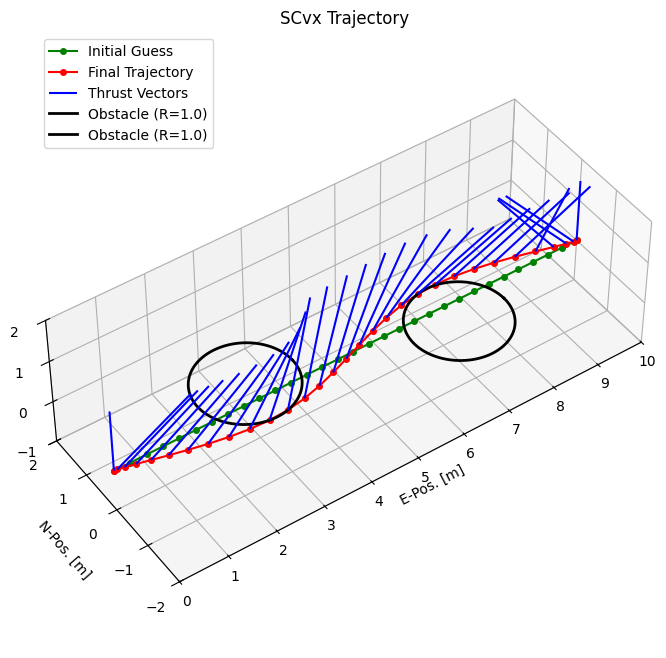

In [47]:
def plot_results(x_k, u_k, x_guess=None):
    pos_final = x_k[:, 0:3]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    if x_guess is not None:
        pos_guess = x_guess[:, 0:3]
        ax.plot(pos_guess[:, 1], pos_guess[:, 2], pos_guess[:, 0], 'g-o',markersize=4, label='Initial Guess')

    ax.plot(pos_final[:, 1], pos_final[:, 2], pos_final[:, 0], 'r-o', markersize=4, label='Final Trajectory')

    thrust_vectors = u_k * 1.0 
    ax.quiver(pos_final[:, 1], pos_final[:, 2], pos_final[:, 0],
            thrust_vectors[:, 1], thrust_vectors[:, 2], thrust_vectors[:, 0],
            color='blue', length=0.5, normalize=False, label='Thrust Vectors',
            arrow_length_ratio=0) 

    for obs in PARAMS['obstacles']:
        p = obs['p_obs']
        r = obs['R_obs']

        theta = np.linspace(0, 2 * np.pi, 100)
        e = p[1] + r * np.cos(theta)
        n = p[2] + r * np.sin(theta)
        u = np.full_like(theta, p[0])
        ax.plot(e, n, u, 'k-', linewidth=2, label=f'Obstacle (R={r})')

    ax.set_xlabel('E-Pos. [m]')
    ax.set_ylabel('N-Pos. [m]')
    ax.set_zlabel('U-Pos. [m]')
    ax.legend(loc='upper left')

    all_pos = np.vstack((pos_guess, pos_final)) if x_guess is not None else pos_final

    zoom_factor = 0.8 
    max_range = np.array([all_pos[:,1].max()-all_pos[:,1].min(), 
                        all_pos[:,2].max()-all_pos[:,2].min(), 
                        all_pos[:,0].max()-all_pos[:,0].min()]).max() / 2.0
    max_range *= zoom_factor 

    x_lim = [0, 10]
    z_lim = [-1, 2]
    y_lim = [-2, 2]

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_zlim(z_lim)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    x_span = x_lim[1] - x_lim[0]
    y_span = y_lim[1] - y_lim[0]
    z_span = z_lim[1] - z_lim[0]

    ax.set_box_aspect([x_span, y_span, z_span])

    ax.view_init(elev=45, azim=235)

    ax.set_title('SCvx Trajectory')
    plt.show()

x_guess, _, _ = create_init_guess()
plot_results(x_k, u_k, x_guess)

### Debug Stuff

Lk Recalc

In [ ]:
def calc_Lk_external(x, u, gamma, x_k, u_k):
    C = np.sum(gamma)*dt
    v = np.zeros((N-1, nx))
    for i in range(N-1):
        A_d, B_dm, B_dp, z_d = get_discrete_matrices_ltv(x_k[i], u_k[i], u_k[i+1])
        v[i] = x[i+1] - (A_d @ x[i] + B_dm @ u[i] + B_dp @ u[i+1] + z_d)

    sp = np.zeros((N, len(PARAMS['obstacles'])))
    for i in range(N):
        for j, obs in enumerate(PARAMS['obstacles']):
            s_obs = s_obs_func(x_k[i], obs)
            S_obs = S_func(x_k[i], obs)
            d = x[i] - x_k[i]
            sp[i][j] = max((s_obs + S_obs @ d)[0], 0)

    v_sum = np.linalg.norm(v, ord=1)
    sp_sum = np.sum(sp)
    print(f'  C = {C}')
    print(f'  v_error = {v_sum}')
    print(f'  s_error = {sp_sum}')
    return C + SCVX_PARAMS['lambda_v']*v_sum + SCVX_PARAMS['lambda_s']*sp_sum

In [ ]:
J0 = J_func(x_k, u_k, gamma_k, verbose=True)

Cost Comparison

In [ ]:
x_k, u_k, gamma_k = create_init_guess()

print('Lk0:')
Lk0 = calc_Lk_external(x_k, u_k, gamma_k, x_k, u_k)
print(f'Total: {Lk0}')

print('J0:')
J0 = J_func(x_k, u_k, gamma_k, verbose=True)
print(f'Total: {J0}')

# r_k = SCVX_PARAMS['r_0']
r_k = 10000.0

for i in range(1):
    solve_result = solve_convex_subproblem(x_k, u_k, r_k, verbose=False)
    x_star, u_star, gamma_star, v_star, sp_star, status, L_k = solve_result

    print(f'\nLk{i+1}:')
    Lki = calc_Lk_external(x_star.value, u_star.value, gamma_star.value, x_k, u_k)
    print(f'Total: {Lki}')

    print(f'J{i+1}:')
    Ji = J_func(x_star.value, u_star.value, gamma_star.value, verbose=True)
    print(f'Total: {Ji}')

    x_k, u_k, gamma_k = x_star.value, u_star.value, gamma_star.value

In [ ]:
plot_results(x_k, u_k)

Comparison of Dynamic Errors

In [ ]:
x_0 = np.array([1, 2, 3, 3, 2, 1])
u_0 = np.array([1, 2, 3])
u_1 = np.array([3, 1, 0])

err = 0.1
A_lti, Bm_lti, Bp_lti, z_lti = get_discrete_matrices(x_0+err, u_0+err)
A_ltv, Bm_ltv, Bp_ltv, z_ltv = get_discrete_matrices_ltv(x_0+err, u_0+err, u_1+err)
x_1_lti = A_lti @ x_0 + Bm_lti @ u_0 + Bp_lti @ u_1 + z_lti

def f_FOH(t: float, x: np.ndarray, u_i0: np.ndarray, u_i1: np.ndarray):
    # Calculates the FOH on the input and plugs into the non-linear dynamics
    beta_m = (dt - t)/dt
    beta_p = t / dt
    u_t = beta_m*u_i0 + beta_p*u_i1
    return f_func(x, u_t)

# numerically integrate the real dynamics one dt
sol = solve_ivp(
    f_FOH,
    [0, dt],
    x_0,
    args = (u_0, u_1)
)

x_1_real = sol.y[:, -1]

x_1_ltv = A_ltv @ x_0 + Bm_ltv @ u_0 + Bp_ltv @ u_1 + z_ltv

print('Real: ',x_1_real)
print('LTI:  ',x_1_lti)
print('LTV:  ',x_1_ltv)
print(f'\nLTI Error: {np.linalg.norm(x_1_real - x_1_lti)}')
print(f'\nLTV Error: {np.linalg.norm(x_1_real - x_1_ltv)}')

### A Very Manual Integration...I am going insane

In [49]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

def f_FOH(t: float, x: np.ndarray, u_i0: np.ndarray, u_i1: np.ndarray):
    # Calculates the FOH on the input and plugs into the non-linear dynamics
    beta_m = (dt - t)/dt
    beta_p = t / dt
    u_t = beta_m*u_i0 + beta_p*u_i1
    return f_func(x, u_t)

v_error = np.zeros((N-1, nx))
for i in range(N-1): # N total x and u
    x_i0 = x_k[i]
    x_i1 = x_k[i+1]
    u_i0 = u_k[i]
    u_i1 = u_k[i+1]

    # numerically integrate the real dynamics one dt
    sol = solve_ivp(
        f_FOH,
        [0, dt],
        x_i0,
        args = (u_i0, u_i1)
    )
    
    # v_error += np.linalg.norm(x_i1 - sol.y[:,-1], ord = 1)
    err = np.sum(np.abs(x_i1 - sol.y[:,-1]))
    v_error[i] = np.abs(x_i1 - sol.y[:,-1])
    print(f'Node {i}-{i+1} Error: {err}')
    print(f"{x_i1} - \n{sol.y[:,-1]} = \n{x_i1 - sol.y[:,-1]}\n")
print(f'Sum: {np.sum(v_error)}')
print(f'Sum Pos Error: {np.sum(v_error[:, 0:3])}')
print(f'Sum Vel Error: {np.sum(v_error[:, 3:6])}')

Node 0-1 Error: 7.244782056535544e-06
[-0.00 0.06 -0.00 0.00 0.91 -0.14] - 
[0.00 0.06 -0.00 0.00 0.91 -0.14] = 
[-0.00 -0.00 0.00 -0.00 -0.00 0.00]

Node 1-2 Error: 1.7490568860322787e-06
[0.00 0.19 -0.03 0.00 1.68 -0.40] - 
[0.00 0.19 -0.03 0.00 1.68 -0.40] = 
[-0.00 -0.00 0.00 -0.00 -0.00 0.00]

Node 2-3 Error: 1.2950443407465738e-06
[-0.00 0.39 -0.08 0.00 2.33 -0.61] - 
[0.00 0.39 -0.08 0.00 2.33 -0.61] = 
[-0.00 -0.00 0.00 -0.00 -0.00 0.00]

Node 3-4 Error: 1.7393225759798243e-06
[0.00 0.65 -0.15 0.00 2.85 -0.75] - 
[0.00 0.65 -0.15 0.00 2.85 -0.75] = 
[-0.00 -0.00 0.00 -0.00 -0.00 0.00]

Node 4-5 Error: 1.005167258820847e-06
[0.00 0.96 -0.23 -0.00 3.25 -0.83] - 
[0.00 0.96 -0.23 -0.00 3.25 -0.83] = 
[-0.00 -0.00 0.00 -0.00 -0.00 0.00]

Node 5-6 Error: 1.3851051435118055e-06
[-0.00 1.30 -0.32 0.00 3.54 -0.84] - 
[-0.00 1.30 -0.32 0.00 3.54 -0.84] = 
[0.00 -0.00 0.00 -0.00 -0.00 0.00]

Node 6-7 Error: 2.564179546276823e-06
[0.00 1.67 -0.40 0.00 3.75 -0.77] - 
[0.00 1.67 -0.40 0.00 

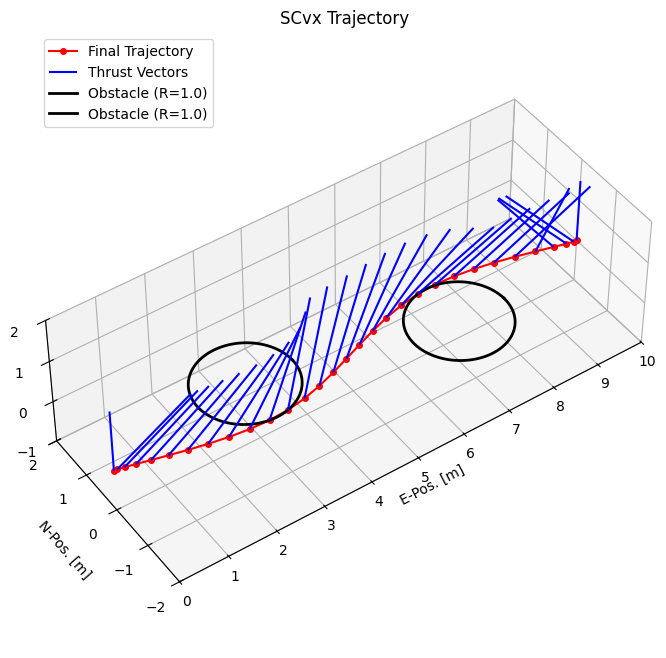

In [50]:
x_k_real = np.zeros((N, nx))
x_k_real[0] = x_k[0]
for i in range(N-1): # N total x and u
    x_i0 = x_k_real[i]
    x_i1 = x_k_real[i+1]
    u_i0 = u_k[i]
    u_i1 = u_k[i+1]

    # numerically integrate the real dynamics one dt
    sol = solve_ivp(
        f_FOH,
        [0, dt],
        x_i0,
        args = (u_i0, u_i1)
    )
    x_k_real[i+1] = sol.y[:, -1]

plot_results(x_k_real, u_k)